In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 3.5 MB 7.3 MB/s 


In [38]:
# For all examples in this section we use the following imports.
# Note that we are using torch_geometric's DataLoader.
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
# let's load the QM9 small molecule dataset
dset = QM9('.')
print(len(dset))

# Here's how torch geometric wraps data
data = dset[0]
print(data)
# can access attributes directly
print(data.y)
# the atomic number of each atom can add attributes
data.new_attribute = torch.tensor([1, 2, 3])
data
# can move all attributes between devices
device = torch.device(
"cuda:0" if torch.cuda.is_available() else "cpu"
)
data.to(device)
data.new_attribute.is_cuda

130831
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])


False

In [15]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
        nn.Linear(num_edge_features, 32),
        nn.ReLU(),
        nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
        nn.Linear(num_edge_features, 32),
        nn.ReLU(),
        nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
        data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [26]:
from torch.utils.data import random_split
train_set, valid_set, test_set = random_split(
dset,[110000, 10831, 10000])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [37]:
# This cell plots a molecule for us. Go ahead and try a couple of random molecules, it's fun!
import plotly.graph_objects as go
axis = dict(
    showbackground=False,
    showticklabels=False,
    showgrid=False,
    zeroline=False,
    title='',
)
layout = dict(
    showlegend=False,
    scene=dict(
        aspectmode="data",
        xaxis=dict(
            **axis,
        ),
        yaxis=dict(
            **axis,
        ),
        zaxis=dict(
            **axis,
        ),
    ),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=0, r=0, t=0, b=0)
)
def visualise_molecule(graph):
  """ Plot a molecule based on a graph from QM9 """
  pos = graph.pos.clone()
  edge_index = graph.edge_index

  pos = (pos - pos.mean(0))/pos.std(0)

  x = pos[:, 0]
  y = pos[:, 1]
  z = pos[:, 2]
  
  atom_type = (1+ graph.x[:, :5].argmax(-1))*10
  
  pos = pos[edge_index]
  data = [go.Scatter3d(x=x, y=y, z=z,mode='markers', marker=dict(size=atom_type, color=atom_type))]
  for i in range(edge_index.size(-1)):
    line_data = pos[:, i, :]

    data.append(go.Scatter3d(x=line_data[:, 0], y=line_data[:, 1], z=line_data[:, 2], 
                               mode="lines", 
                               line=dict(
                                     color='black',
                                     width=3,
                                 )
                               )
    )

  fig = go.Figure(data=data, layout=layout)  
  return fig
#random_idx = np.random.randint(len(train_set)) 
#graph = train_set[random_idx]
#print(train_set[random_idx])
fig = visualise_molecule(dset[0])
fig.show()

In [17]:
# initialize a network
qm9_node_feats, qm9_edge_feats = 11, 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)
# initialize an optimizer with some reasonable parameters
optimizer = torch.optim.Adam(
net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label
device = torch.device("cuda:0" if
torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [18]:
for total_epochs in range(epochs):
	epoch_loss = 0
	total_graphs = 0
	net.train()
	for batch in trainloader:
		batch.to(device)
		optimizer.zero_grad()
		output = net(batch)
		loss = F.mse_loss(
		output,batch.y[:, target_idx].unsqueeze(1))
		loss.backward()
		epoch_loss += loss.item()
		total_graphs += batch.num_graphs
		optimizer.step()
	train_avg_loss = epoch_loss / total_graphs
	val_loss = 0
	total_graphs = 0
	net.eval()
	for batch in validloader:
		batch.to(device)
		output = net(batch)
		loss = F.mse_loss(
		output,batch.y[:, target_idx].unsqueeze(1))
		val_loss += loss.item()
		total_graphs += batch.num_graphs
	val_avg_loss = val_loss / total_graphs
	print(f"Epochs: {total_epochs} | "
	f"epoch avg. loss: {train_avg_loss:.2f} | "
	f"validation avg. loss: {val_avg_loss:.2f}")


Epochs: 0 | epoch avg. loss: 0.72 | validation avg. loss: 0.20
Epochs: 1 | epoch avg. loss: 0.14 | validation avg. loss: 0.08
Epochs: 2 | epoch avg. loss: 0.11 | validation avg. loss: 0.18
Epochs: 3 | epoch avg. loss: 0.10 | validation avg. loss: 0.07


In [19]:
net.eval()
predictions = []
real = []
for batch in testloader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:,target_idx] .detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

Text(0, 0.5, 'Predicted isotropic polarizability')

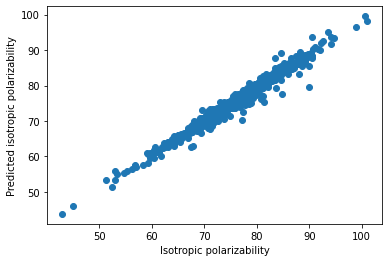

In [20]:
import matplotlib.pyplot as plt
plt.scatter(real[:500], predictions[:500])
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')